In [ ]:
!pip install monai
!pip install nibabel
!pip install einops

In [1]:
import os
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

import torch
import einops
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    Transform,
)

2024-07-28 21:52:52.611186: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 21:52:52.611250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 21:52:52.612941: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/tmp/tmp7vokk_ew


In [ ]:
import json

data = {
    
  "description": "Pancreatic_tumor",
  "labels": {
    "0": "background",
    "1": "pancreas",
    "2": "cancer"
  },
  "licence": "yt",
  "modality": {
    "0": "CT"
  },
  "name": "pancreas",
  "numTest": 15,
  "numTraining": 123,
  "reference": "Megathlon",
  "release": "1.0 06/08/2015",
  "tensorImageSize": "3D",
  "test": [
    
    "/media/systemx86/A23089D03089AC3B1/Users/arunk/Music/NIT_DATA/Task07_Pancreas/Task07_Pancreas/imagesTs/pancreas_044.nii",
    "/media/systemx86/A23089D03089AC3B1/Users/arunk/Music/NIT_DATA/Task07_Pancreas/Task07_Pancreas/imagesTs/pancreas_144.nii",
    
  ],
    "training": [
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_001_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_001_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_004_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_004_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_005_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_005_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_006_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_006_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_010_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_010_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_012_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_012_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_015_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_015_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_018_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_018_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_019_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_019_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_021_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_021_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_024_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_024_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_046_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_046_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_048_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_048_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_055_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_055_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_056_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_056_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_061_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_061_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_064_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_064_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_069_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_069_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_070_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_070_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_071_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_071_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_075_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_075_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_077_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_077_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_080_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_080_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_083_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_083_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_088_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_088_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_089_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_089_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_093_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_093_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_096_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_096_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_098_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_098_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_100_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_100_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_103_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_103_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_113_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_113_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_114_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_114_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_119_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_119_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_122_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_122_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_124_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_124_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_125_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_125_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_127_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_127_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_137_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_137_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_138_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_138_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_155_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_155_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_159_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_159_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_166_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_166_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_167_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_167_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_169_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_169_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_180_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_180_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_181_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_181_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_187_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_187_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_194_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_194_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_198_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_198_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_199_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_199_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_200_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_200_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_209_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_209_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_210_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_210_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_211_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_211_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_213_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_213_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_218_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_218_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_219_1.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_219_1.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_226_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_226_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_227_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_227_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_229_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_229_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_230_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_230_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_231_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_231_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_234_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_234_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_236_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_236_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_241_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_241_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_244_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_244_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_249_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_249_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_254_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_254_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_255_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_255_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_256_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_256_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_259_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_259_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_261_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_261_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_264_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_264_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_270_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_270_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_274_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_274_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_275_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_275_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_277_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_277_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_278_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_278_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_280_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_280_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_283_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_283_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_284_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_284_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_287_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_287_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_289_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_289_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_290_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_290_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_291_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_291_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_292_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_292_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_293_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_293_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_294_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_294_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_295_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_295_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_297_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_297_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_298_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_298_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_300_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_300_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_301_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_301_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_302_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_302_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_309_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_309_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_311_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_311_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_315_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_315_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_325_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_325_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_327_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_327_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_330_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_330_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_331_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_331_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_333_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_333_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_364_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_364_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_365_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_365_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_367_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_367_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_369_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_369_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_370_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_370_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_372_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_372_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_374_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_374_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_375_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_375_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_376_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_376_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_379_3.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_379_3.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_389_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_389_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_391_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_391_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_393_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_393_0.nii"
    },
   # {
     #   "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_409_6.nii",
   #     "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_409_6.nii"
   # },
    #{
    
     #   "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_409_7.nii",
     #   "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_409_7.nii"
    #},
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_410_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_410_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_411_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_411_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_412_1.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_412_1.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_413_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_413_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_414_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_414_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_414_1.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_414_1.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/images/pancreas_421_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_images/labels/pancreas_421_0.nii"
    }
    ],
    
    "validation": [
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_005_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_005_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_012_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_012_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_015_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_015_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_048_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_048_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_061_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_061_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_069_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_069_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_075_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_075_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_080_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_080_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_089_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_089_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_100_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_100_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_103_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_103_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_114_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_114_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_122_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_122_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_127_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_127_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_180_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_180_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_198_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_198_0.nii"
    },
    
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_199_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_199_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_213_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_213_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_227_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_227_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_236_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_236_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_249_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_249_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_261_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_261_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_270_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_270_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_283_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_283_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_291_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_291_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_293_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_293_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_301_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_301_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_333_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_333_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_365_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_365_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_367_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_367_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_372_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_372_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_374_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_374_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_376_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_376_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_389_0.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_389_0.nii"
    },
    {
        "image": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/images/pancreas_414_1.nii",
        "label": "/kaggle/input/pancreas-tumor-nii-80slice/NIT_Data/NIT_Data/nifti_val/labels/pancreas_414_1.nii"
    },
        
  
    ],
}
with open('dataset_0.json', 'w') as outfile:
    json.dump(data, outfile, indent=2)

print("dataset_0.json has been created.")

In [2]:

# Custom transform wrapper to print shape and filename 
class PrintShapeAndFilename(Transform):
    def __init__(self, message):
        self.message = message

    def __call__(self, data):
        image, label = data["image"], data["label"]
        filename = data["image"].meta["filename_or_obj"]  # Get filename
        print(f"{self.message} - Filename: {filename}, Image shape: {image.shape}, Label shape: {label.shape}")
        return data

# Define transforms
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        #PrintShapeAndFilename("After LoadImaged"),
        EnsureChannelFirstd(keys=["image", "label"]),
        #PrintShapeAndFilename("After EnsureChannelFirstd"),
        Orientationd(keys=["image", "label"], axcodes="LAS"),
        #PrintShapeAndFilename("After Orientationd"),
        Spacingd(keys=["image", "label"], pixdim=(1.15, 1.15, 1.15), mode=("bilinear", "nearest")),
        #PrintShapeAndFilename("After Spacingd"),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        #PrintShapeAndFilename("After ScaleIntensityRanged"),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        #PrintShapeAndFilename("After CropForegroundd"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(128,128,80),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        #PrintShapeAndFilename("After RandCropByPosNegLabeld"),
        RandFlipd(keys=["image", "label"], spatial_axis=[0], prob=0.10),
        #PrintShapeAndFilename("After RandFlipd (axis=0)"),
        RandFlipd(keys=["image", "label"], spatial_axis=[1], prob=0.10),
        #PrintShapeAndFilename("After RandFlipd (axis=1)"),
        RandFlipd(keys=["image", "label"], spatial_axis=[2], prob=0.10),
        #PrintShapeAndFilename("After RandFlipd (axis=2)"),
        RandRotate90d(keys=["image", "label"], prob=0.10, max_k=3),
        #PrintShapeAndFilename("After RandRotate90d"),
        RandShiftIntensityd(keys=["image"], offsets=0.10, prob=0.50),
        #PrintShapeAndFilename("After RandShiftIntensityd"),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        #PrintShapeAndFilename("After LoadImaged"),
        EnsureChannelFirstd(keys=["image", "label"]),
        #PrintShapeAndFilename("After EnsureChannelFirstd"),
        Orientationd(keys=["image", "label"], axcodes="LAS"),
        #PrintShapeAndFilename("After Orientationd"),
        Spacingd(keys=["image", "label"], pixdim=(1.15 , 1.15 , 1.15), mode=("bilinear", "nearest")),
        #PrintShapeAndFilename("After Spacingd"),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        #PrintShapeAndFilename("After ScaleIntensityRanged"),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        #PrintShapeAndFilename("After CropForegroundd"),
    ]
)

/opt/conda/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [3]:

# Load data
data_dir = "/kaggle/working/"
split_json = "dataset_0.json"

datasets = os.path.join(data_dir, split_json)
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")

train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=85,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

val_ds = CacheDataset(
    data=val_files,
    transform=val_transforms,
    cache_num=25,
    cache_rate=1.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

# Example of printing shape after transformation (for debugging)
example_data = next(iter(train_loader))
print(f"Final Image shape: {example_data['image'].shape}")
print(f"Final Label shape: {example_data['label'].shape}")

Loading dataset: 100%|██████████| 25/25 [01:07<00:00,  2.71s/it]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Final Image shape: torch.Size([4, 1, 128, 128, 80])
Final Label shape: torch.Size([4, 1, 128, 128, 80])


image shape: torch.Size([1, 319, 283, 173]), label shape: torch.Size([1, 319, 283, 173])


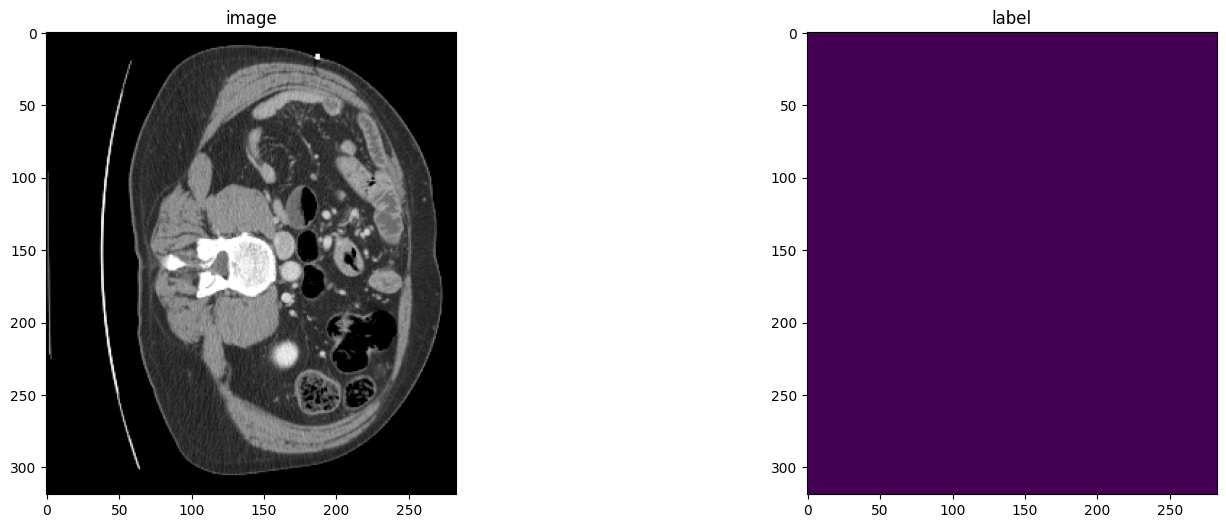

In [4]:
slice_map = {
    "pancreas_012_0.nii":20,
    "pancreas_005_0.nii":70
        }
case_num = 1
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [5]:
import torch; print(torch.cuda.is_available())

True


In [6]:
import einops
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=3,
    img_size=(128,128,80),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    proj_type="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)
'''
# Define the class weights
class_weights = torch.tensor([0.33, 148.1, 651.61], device=device)

# Create the DiceCELoss with weights
loss_function = DiceCELoss(
    to_onehot_y=True,
    softmax=True,
    weight=class_weights
)
'''
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (128,128,80), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))  # noqa: B038
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(  # noqa: B038
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best



In [ ]:
max_iterations = 25000
eval_num = 500
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (500 / 25000 Steps) (loss=0.91458):   7%|▋         | 9/123 [02:10<1:09:17, 36.47s/it]

Model Was Saved ! Current Best Avg. Dice: 0.33511215448379517 Current Avg. Dice: 0.33511215448379517


Training (1000 / 25000 Steps) (loss=0.78343):  14%|█▍        | 17/123 [02:11<53:36, 30.35s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3852400481700897 Current Avg. Dice: 0.3852400481700897


Training (1500 / 25000 Steps) (loss=0.72924):  20%|██        | 25/123 [02:06<47:52, 29.31s/it]

Model Was Saved ! Current Best Avg. Dice: 0.42543771862983704 Current Avg. Dice: 0.42543771862983704


Training (2000 / 25000 Steps) (loss=0.67963):  27%|██▋       | 33/123 [02:22<44:12, 29.47s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4457119405269623 Current Avg. Dice: 0.4457119405269623


Training (2500 / 25000 Steps) (loss=0.64000):  33%|███▎      | 41/123 [02:47<40:32, 29.66s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4912690222263336 Current Avg. Dice: 0.4912690222263336


Training (3000 / 25000 Steps) (loss=0.63728):  40%|███▉      | 49/123 [02:54<37:10, 30.14s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5267924666404724 Current Avg. Dice: 0.5267924666404724


Training (3500 / 25000 Steps) (loss=0.57400):  46%|████▋     | 57/123 [03:08<32:41, 29.73s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5772097110748291 Current Avg. Dice: 0.5772097110748291


Training (4000 / 25000 Steps) (loss=0.63209):  53%|█████▎    | 65/123 [03:14<28:34, 29.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5772097110748291 Current Avg. Dice: 0.5740898251533508


Training (4500 / 25000 Steps) (loss=0.78276):  59%|█████▉    | 73/123 [03:31<27:33, 33.06s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6108458638191223 Current Avg. Dice: 0.6108458638191223


Training (5000 / 25000 Steps) (loss=0.68726):  66%|██████▌   | 81/123 [03:37<20:55, 29.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6108458638191223 Current Avg. Dice: 0.5957478284835815


Training (5411 / 25000 Steps) (loss=0.51626):  99%|█████████▉| 122/123 [03:09<00:01,  1.57s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training (7500 / 25000 Steps) (loss=0.52704):  98%|█████████▊| 121/123 [04:33<00:57, 28.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6594427824020386 Current Avg. Dice: 0.6584813594818115


Training (8000 / 25000 Steps) (loss=0.39431):   5%|▍         | 6/123 [01:50<1:05:06, 33.39s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6910189986228943 Current Avg. Dice: 0.6910189986228943


Training (8500 / 25000 Steps) (loss=0.55426):  11%|█▏        | 14/123 [01:57<52:43, 29.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6910189986228943 Current Avg. Dice: 0.6891977190971375


Training (9257 / 25000 Steps) (loss=0.59823):  27%|██▋       | 33/123 [00:48<01:43,  1.15s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


Training (9500 / 25000 Steps) (loss=0.65008):  24%|██▍       | 30/123 [02:28<47:11, 30.45s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7031890749931335 Current Avg. Dice: 0.7031890749931335


Training (10000 / 25000 Steps) (loss=0.57878):  31%|███       | 38/123 [02:38<42:34, 30.05s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7159452438354492 Current Avg. Dice: 0.7159452438354492


Training (10500 / 25000 Steps) (loss=0.41322):  37%|███▋      | 46/123 [02:46<37:08, 28.94s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7273661494255066 Current Avg. Dice: 0.7273661494255066


Training (11000 / 25000 Steps) (loss=0.48395):  44%|████▍     | 54/123 [02:59<34:08, 29.70s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7424936294555664 Current Avg. Dice: 0.7424936294555664


Training (11500 / 25000 Steps) (loss=0.47681):  50%|█████     | 62/123 [03:13<29:34, 29.08s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7424936294555664 Current Avg. Dice: 0.7022133469581604


Training (12000 / 25000 Steps) (loss=0.42623):  57%|█████▋    | 70/123 [03:30<26:17, 29.76s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7459405660629272 Current Avg. Dice: 0.7459405660629272


Training (12500 / 25000 Steps) (loss=0.47988):  63%|██████▎   | 78/123 [03:29<22:27, 29.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7459405660629272 Current Avg. Dice: 0.7381828427314758


Training (13000 / 25000 Steps) (loss=0.56665):  70%|██████▉   | 86/123 [03:56<18:10, 29.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7459405660629272 Current Avg. Dice: 0.7362112402915955


Training (13500 / 25000 Steps) (loss=0.39251):  76%|███████▋  | 94/123 [04:01<14:28, 29.94s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7480950951576233 Current Avg. Dice: 0.7480950951576233


Training (14000 / 25000 Steps) (loss=0.40433):  83%|████████▎ | 102/123 [04:15<10:53, 31.11s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7584388852119446 Current Avg. Dice: 0.7584388852119446


Training (14500 / 25000 Steps) (loss=0.49638):  89%|████████▉ | 110/123 [04:24<06:41, 30.90s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7741060853004456 Current Avg. Dice: 0.7741060853004456


Training (15000 / 25000 Steps) (loss=0.57421):  96%|█████████▌| 118/123 [04:41<02:31, 30.40s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7824627757072449 Current Avg. Dice: 0.7824627757072449


Training (15500 / 25000 Steps) (loss=0.44073):   2%|▏         | 3/123 [01:40<1:29:55, 44.96s/it]

Model Was Saved ! Current Best Avg. Dice: 0.789198637008667 Current Avg. Dice: 0.789198637008667


Training (16000 / 25000 Steps) (loss=0.45280):   9%|▉         | 11/123 [01:55<55:24, 29.68s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7954531311988831 Current Avg. Dice: 0.7954531311988831


Training (16500 / 25000 Steps) (loss=0.55144):  15%|█▌        | 19/123 [02:05<50:51, 29.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7954531311988831 Current Avg. Dice: 0.7728608250617981


Training (17000 / 25000 Steps) (loss=0.36104):  22%|██▏       | 27/123 [02:16<47:42, 29.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7954531311988831 Current Avg. Dice: 0.7880993485450745


Training (17500 / 25000 Steps) (loss=0.63149):  28%|██▊       | 35/123 [02:30<42:31, 29.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7954531311988831 Current Avg. Dice: 0.791266918182373


Training (18000 / 25000 Steps) (loss=0.43933):  35%|███▍      | 43/123 [02:44<38:12, 28.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7954531311988831 Current Avg. Dice: 0.7745764851570129


Training (18500 / 25000 Steps) (loss=0.57816):  41%|████▏     | 51/123 [03:00<36:31, 30.44s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8102107644081116 Current Avg. Dice: 0.8102107644081116


Training (19000 / 25000 Steps) (loss=0.45761):  48%|████▊     | 59/123 [03:08<31:08, 29.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8102107644081116 Current Avg. Dice: 0.7992362976074219


Training (19500 / 25000 Steps) (loss=0.53553):  54%|█████▍    | 67/123 [03:10<27:07, 29.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8102107644081116 Current Avg. Dice: 0.7886046171188354


Training (20000 / 25000 Steps) (loss=0.36260):  61%|██████    | 75/123 [03:24<23:25, 29.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8102107644081116 Current Avg. Dice: 0.7923144698143005


Training (20500 / 25000 Steps) (loss=0.36334):  67%|██████▋   | 83/123 [03:44<19:35, 29.38s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8174269199371338 Current Avg. Dice: 0.8174269199371338


Training (21000 / 25000 Steps) (loss=0.66956):  74%|███████▍  | 91/123 [03:46<15:25, 28.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8174269199371338 Current Avg. Dice: 0.7968429327011108


Training (21500 / 25000 Steps) (loss=0.55571):  80%|████████  | 99/123 [03:58<11:42, 29.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8174269199371338 Current Avg. Dice: 0.8153435587882996


Training (22000 / 25000 Steps) (loss=0.19060):  87%|████████▋ | 107/123 [04:25<07:56, 29.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8286867141723633 Current Avg. Dice: 0.8286867141723633


Training (22500 / 25000 Steps) (loss=0.44995):  93%|█████████▎| 115/123 [04:26<03:54, 29.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8286867141723633 Current Avg. Dice: 0.8190878629684448


Training (23000 / 25000 Steps) (loss=0.38614): 100%|██████████| 123/123 [04:45<00:00, 28.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8286867141723633 Current Avg. Dice: 0.8234124779701233


Training (23500 / 25000 Steps) (loss=0.38277):   7%|▋         | 8/123 [01:49<58:33, 30.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8286867141723633 Current Avg. Dice: 0.8101043105125427


Training (23523 / 25000 Steps) (loss=0.39397):  25%|██▌       | 31/123 [02:16<02:14,  1.46s/it]